In [7]:
import CalculateCoElutionScores as CS
#os.chdir("/home/EPIC/src")
import utils as utils

from ipywidgets import widgets, interact, interactive
from IPython.display import HTML, display# Basic CyRest Setup
import json, os, sys

def f(**kwargs):
    return None

features_i = interactive(f, MI=False, Bayes=False, Euclidean=False, WCC=False, Jaccard=False, PCCN=False, PCC=False, Apex=False)
directoryName_i = interactive(f, directory="input directory")
num_cores_i = interactive(f, num_cores="1")
clf_i = interactive(f, classifier=("random forest", "SVM"))
target_species_i = interactive(f, target_species="taxid i.e. 6239 (Worm)")
display(features_i)
display(directoryName_i)
display(num_cores_i)
display(clf_i)
display(target_species_i)

In [8]:
featuer_selection = [features_i.kwargs[feature_name] for feature_name in ['PCC', 'Jaccard', 'Apex', 'MI', 'Euclidean',  'WCC', 'Bayes', 'PCCN'] ]
num_cores = int(num_cores_i.kwargs['num_cores'])
root_dir = "/Users/florian/workspace/scratch/EPIC_out/" #"/home/"
name = directoryName_i.kwargs['directory']
input_dir = root_dir + 'input' + os.sep + name
output_dir = root_dir + 'output' + os.sep + name
if os.path.exists(output_dir) == False: 
    os.mkdir(output_dir)
else:
    print "Output dir already exists"
#    sys.exit()
output_dir += os.sep + "Out"
target_taxid = target_species_i.kwargs['target_species']
use_rf = clf_i.kwargs['classifier'] != 'SVM'
if use_rf:
    output_dir += ".rf"
else:
    output_dir += ".svm"
mode= "exp"

#Stdout for debug
print num_cores
print(featuer_selection)
print use_rf
print target_taxid
print input_dir
print output_dir


Output dir already exists
4
[False, False, False, True, False, False, True, True]
True
6239
/Users/florian/workspace/scratch/EPIC_out/input/Test
/Users/florian/workspace/scratch/EPIC_out/output/Test/Out.rf


In [9]:
#Create feature combination
all_scores = [CS.Pearson(), CS.Jaccard(), CS.Apex(), CS.MutualInformation(2), CS.Euclidiean(), CS.Wcc(), CS.Bayes(3), CS.Poisson(5)]
this_scores = []
for i, selection in enumerate(featuer_selection):
	if selection: this_scores.append(all_scores[i])
print this_scores


[<CalculateCoElutionScores.MutualInformation instance at 0x11b56f3f8>, <CalculateCoElutionScores.Bayes instance at 0x11b56f680>, <CalculateCoElutionScores.Poisson instance at 0x11b56f6c8>]


In [10]:
# Initialize CLF
clf = CS.CLF_Wrapper(num_cores, use_rf)

using Random forest


In [11]:
# load elution data
foundprots, elution_datas = utils.load_data(input_dir, this_scores)

finished processing /Users/florian/workspace/scratch/EPIC_out/input/Test/BeadsA_Contrast_1000_fraction_99.txtmodifed.txt
 removed 591 (0.32) proteins with counts in only one fraction


CalculateCoElutionScores.py:204: RuntimeWarning: invalid value encountered in true_divide
  return np.asarray(np.nan_to_num(mat / np.sum(mat, axis)))


0


/Users/florian/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/florian/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1
2
3
4
finished processing /Users/florian/workspace/scratch/EPIC_out/input/Test/BeadsALF_Contrast_1000_fraction_99.txtmodifed.txt
 removed 563 (0.32) proteins with counts in only one fraction
0
1
2
3
4
finished processing /Users/florian/workspace/scratch/EPIC_out/input/Test/BeadsB_Contrast_1000_fraction_99.txtmodifed.txt
 removed 571 (0.28) proteins with counts in only one fraction
0
1
2
3
4
finished processing /Users/florian/workspace/scratch/EPIC_out/input/Test/BeadsBNF_Contrast_1000_fraction_99.txtmodifed.txt
 removed 471 (0.28) proteins with counts in only one fraction
0
1
2
3
4


In [12]:
# Generate reference data set
all_gs = utils.create_goldstandard(target_taxid, foundprots)

Total number of complexes 2791 in Training
Number of complexes after ortholog mapping 1777 complexes in Training
After size filtering 747 number of complexes in Training
After mergning 556 number of complexes in Training
After removing not indetified proteins 135 number of complexes in Training


In [13]:
# Caculating scores
scoreCalc = CS.CalculateCoElutionScores(this_scores, elution_datas, output_dir + ".scores.txt", num_cores=num_cores)
#scoreCalc.calculate_coelutionDatas(gs)
scoreCalc.readTable("/Users/florian/workspace/scratch/EPIC_out/output/test/Test.scores.txt", all_gs)
train, eval = all_gs.split_into_holdout_training(set(scoreCalc.ppiToIndex.keys()))

In [14]:
# Evaluate classifier
utils.bench_clf(scoreCalc, train, eval, clf, output_dir, verbose=True, format="png")

Precision
0.898936170213
Recall
0.477401129944
F-Measure
0.623616236162
AUC PR
0.74226221733
AUC ROC
0.731694665267


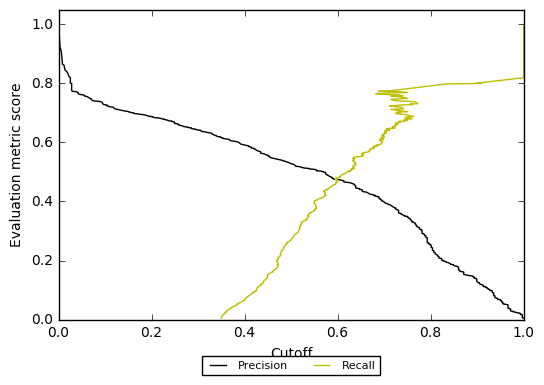

In [9]:
from IPython.display import Image
Image(filename=output_dir + ".cutoff.png")

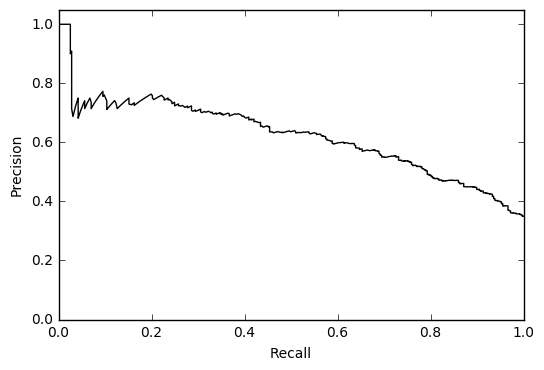

In [10]:
Image(filename=output_dir + ".pr.png")

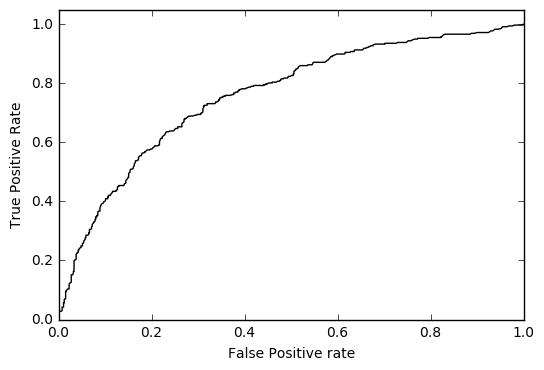

In [11]:
Image(filename=output_dir + ".roc.png")

In [20]:
# Predicting interaction network


genemania = ""
if mode != "exp":
	genemania = CS.Genemania("6239")
	genemania = genemania.getScoreCalc()

# Predict protein interaction
network =  utils.make_predictions(scoreCalc, mode, clf, train, genemania)
outFH = open("%s.%s.pred.txt" % (output_dir, mode), "w")
print >> outFH, "\n".join(network)
outFH.close()

(1723, 12)
to predict: 107180


In [13]:
# Predicting clusters
utils.predict_clusters("%s.%s.pred.txt" % (output_dir, mode), "%s.%s.clust.txt" % (output_dir, mode))

In [44]:
import GoldStandard as GS
# Evaluating predicted clusters
pred_clusters = GS.Clusters(False)
pred_clusters.read_file("%s.%s.clust.txt" % (output_dir, mode))
#utils.clustering_evaluation(train.complexes, pred_clusters, "Train", True)
utils.clustering_evaluation(eval.complexes, pred_clusters, "", True)

 mmr	0.103671131467
 overlapp	0.014599
 simcoe	0.036496
 mean_simcoe_overlap	0.029197
 sensetivity	0.142595978062
 ppv	0.330434782609
 accuracy	0.217068355621
 sep	0.241591680272


GoldStandard.py:416: RuntimeWarning: invalid value encountered in true_divide
  row_F = np.nan_to_num(row_F/np.sum(row_F, axis=1, keepdims=True))
GoldStandard.py:417: RuntimeWarning: invalid value encountered in true_divide
  col_F = np.nan_to_num(col_F/np.sum(col_F, axis=0, keepdims=True))


('0.103671131467\t0.014599\t0.036496\t0.029197\t0.142595978062\t0.330434782609\t0.217068355621\t0.241591680272',
 ' mmr\t overlapp\t simcoe\t mean_simcoe_overlap\t sensetivity\t ppv\t accuracy\t sep')

In [15]:
# Uncomment these lines in order to update the Cytoscape.js extension
# ====================================================================
import notebook.nbextensions
notebook.nbextensions.install_nbextension('https://cdnjs.cloudflare.com/ajax/libs/cytoscape/2.7.14/cytoscape.js', user=True)
# ====================================================================

u'/Users/florian/Library/Jupyter/nbextensions/cytoscape.js'

In [40]:
%%javascript

// Use the Cytoscape.js extension and make cytoscape global
require(['cytoscape','cytoscape-cola', 'cola'], function (cytoscape, cycola, cola) {
    cycola( cytoscape, cola);
});

<IPython.core.display.Javascript object>

In [84]:
def json_to_cy_js(div_id, style, json_str):

	return """
	            <script>
	                $('#cy').show();
	                var cy = window.cy = cytoscape({
	                    container: document.getElementById('%s'),
	                    layout: { name: '%s' },
	                    elements: %s,
	                    style: [
	                     {
	                        selector: 'node',
	                        style: {
	                          'content': 'data(name)',
	                          'font-size': 12,
	                          'text-valign': 'center',
	                          'text-halign': 'center',
	                          'background-color': '#555',
	                          'text-outline-color': '#555',
	                          'text-outline-width': 1.75,
	                          'color': '#fff',
	                          'overlay-padding': 6,
	                          'z-index': 10
	                        }
	                      },
	                      {
	                        selector: 'edge',
	                        style: {
	                          'line-color': 'black',
	                          'width': 'mapData(score, 0,100,1,10)',
	                        }
	                      },
	                    ]
	                });
	            </script>""" % (div_id, style, json_str)

In [85]:
def network_to_js(network):
	cy_elements = []
	nodes = []  # For Cytoscape
	edges = []  # For Cytoscape


	net_nodes = set([])
	for line in network:
		ida, idb, score = line.split("\t")
		net_nodes.add(ida)
		net_nodes.add(idb)
		edge = {
			'group': 'edges',
			'data': {
				'source': ida,
				'target': idb,
				'score': score*100,
			}
		}
		cy_elements.append(edge)
		edges.append(edge)

	for gene in net_nodes:
		node = {
			'group': 'nodes',
			'data': {
				'id': str(gene),
				'name': gene,
			}
		}
		cy_elements.append(node)
		nodes.append(node)

	return json.dumps(cy_elements, default=lambda cy_elements: cy_elements.__dict__)

In [86]:
net_json = network_to_js(network)
net_cy_js = json_to_cy_js("net_cy", "random", net_json)
net_cy_div = widgets.HTML(value="""<div id='net_cy' style="width: 100%; height: 500px; background: #f0f0f0;"></div>""")
net_js_script = widgets.HTML(value = net_cy_js)
display(net_cy_div)
display(net_js_script)

In [52]:
clust_json = utils.clusters_to_json(pred_clusters, network)
clust_cy_js = utils.json_to_cy_js("clust_cy", "cose", clust_json)
clust_cy_div = widgets.HTML(value="""<div id='clust_cy' style="width: 100%; height: 500px; background: #f0f0f0;"></div>""")
clust_js_script = widgets.HTML(value = clust_cy_js)
display(clust_cy_div)
display(clust_js_script)